In [44]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time, os
import random
import seaborn as sns

import astropy
from astropy.io import fits

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorboard.plugins.hparams import api as hp

from tensorflow.keras import activations
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from scipy.stats import bernoulli

from matplotlib.ticker import FormatStrFormatter

In [45]:
np.random.seed(0)
scaler = StandardScaler()

### Conjunto de datos: 

In [46]:
with fits.open('https://github.com/igomezv/cosmo_tools/blob/main/COB_22/Viviana_Acquaviva/DEEP2_uniq_Terapix_Subaru_v1.fits?raw=true') as data:
    df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder()) #see https://numpy.org/devdocs/user/basics.byteswapping.html#changing-byte-ordering

In [47]:
df.head()

,objno_deep2,ra_deep2,dec_deep2,magb,magr,magi,pgal,sfd_ebv,class,subclass,...,ra_subaru,dec_subaru,y,yerr,y_apercor,yerr_aper,yerr_apercor,y(sexflag),y_radius_arcsec,subaru_source
0,11001673,213.868704,51.956445,23.487745,23.143082,22.582092,1.000000,0.010943,b'',b'',...,213.868626,51.956443,21.869627,0.060918,21.926356,0.041955,0.141778,3.0,0.656514,1
1,11001699,213.810471,51.942316,22.067692,20.034674,19.545080,3.000000,0.011014,b'GALAXY',b'',...,213.810455,51.942321,18.757229,0.005813,18.811085,0.004386,0.050987,3.0,0.744269,1
2,11001770,213.848431,51.948876,24.144438,24.103180,24.020006,3.000000,0.010856,b'GALAXY',b'',...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
3,11001800,213.831758,51.952548,25.336836,23.508480,23.081087,0.509809,0.010823,b'GALAXY',b'',...,213.831766,51.952544,22.404269,0.088970,22.535600,0.053497,0.094733,0.0,0.455820,1
4,11001860,213.832550,51.954174,24.382738,23.401484,22.572845,3.000000,0.010827,b'GALAXY',b'',...,213.832574,51.954175,22.242717,0.070760,22.100980,0.033256,0.073067,0.0,0.442022,1


In [49]:
features = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']]
features.head()

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor
0,23.543491,23.430495,23.100311,22.768970,22.223810,21.926356
1,30.848978,28.989668,19.027422,99.000000,99.000000,18.811085
2,24.324670,24.273606,24.150319,23.446252,23.574236,-99.000000
3,99.000000,24.804309,23.636544,23.009222,22.689591,22.535600
4,24.362068,24.136913,23.490342,22.777181,22.319676,22.100980


In [50]:
target = df['zhelio']
target.head()

0    1.115261
1    0.290608
2    0.605744
3    1.306796
4    0.957669
Name: zhelio, dtype: float32

In [51]:
# Produces test split.
X_train, X_val, Y_train, Y_val = train_test_split(features, target)

### Arquitectura del modelo proveniente de la malla de hiperparámetros

In [52]:
# loss -> val_loss
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=200,
                                   restore_best_weights=True, verbose=False)
                                   ]

n_cols = 1
epochs=200

In [53]:
def train_test_model(hparams):    
    
    # Train LSTM model and predict on validation set
    model = tf.keras.Sequential()
    model.add(Dense(int(X_train.shape[1])))
    
    for i in range(hparams['HP_LAYERS']):        
        model.add(Dense(hparams['HP_NUM_UNITS'], activation='relu'))
    model.add(Dense(1, activation='linear'))
     
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams['HP_LEARNING'], beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(
            optimizer=optimizer,
            loss='mse', 
            metrics=['mean_squared_error'])
    
    # Run with 1 epoch to speed things up for demo purposes

    train = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val),
              callbacks=callbacks, batch_size=hparams['HP_BATCHSIZE'], shuffle=False, verbose=False)

    _, loss = model.evaluate(X_val, Y_val)
    
    return model, loss, train.history

In [54]:
hparams = {'HP_LAYERS': 4, 'HP_NUM_UNITS': 200, 'HP_BATCHSIZE': 16, 'HP_LEARNING':0.0001}

In [55]:
model1, loss_test1, history1 = train_test_model(hparams)

187/187 [==============================] - 0s 671us/step - loss: 0.1818 - mean_squared_error: 0.1818


Text(0.5, 1.0, 'Grid')

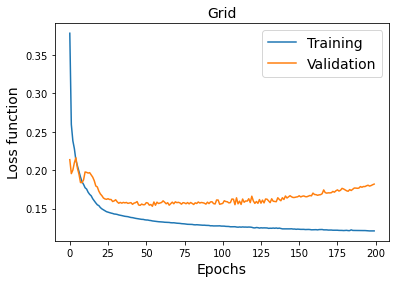

In [56]:
plt.plot(history1['loss'], label='Training')
plt.plot(history1['val_loss'], label='Validation')
plt.ylabel('Loss function', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
# plt.ylim(-5, 210)
plt.legend(loc='upper right', fontsize=14)
plt.title("Grid", fontsize=14)
# plt.savefig("loss_jla_grid.png")

In [57]:
print("number of epochs", len(history1['loss']))

number of epochs 200


In [58]:
model1.save("models/model_zphoto.h5")

In [59]:
loss_test1

0.18182045221328735

In [60]:
zpred = model1.predict(X_val)

187/187 [==============================] - 0s 600us/step


Text(0, 0.5, 'ANN prediction for redshift')

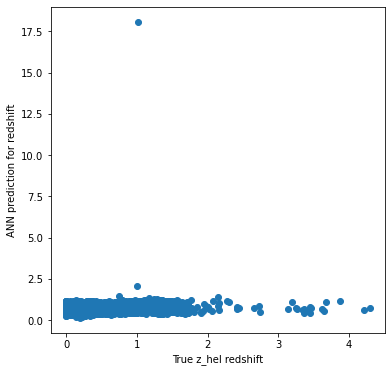

In [61]:
plt.figure(figsize=(6,6))
plt.scatter(Y_val, zpred)
plt.xlabel("True z_hel redshift")
plt.ylabel("ANN prediction for redshift")
